## Intéraction entre les bactéries et les phages

In [79]:
import pandas as pd

df = pd.read_excel("data/InteractionsPhages_PseudomonasAeruginosa_Revised.xlsx")
df

,bacterium_id,bacteriophage_id
0,5160,5281
1,5161,5281
2,5164,5281
3,5166,5281
4,5167,5281
...,...,...
270,5190,5322
271,5192,5322
272,5194,5322
273,5163,5323


In [80]:
print("Nombre d'id de bactérie différent : ", len(df["bacterium_id"].unique()))
print("Nombre d'id de bactériophage différent : ", len(df["bacteriophage_id"].unique()))

Nombre d'id de bactérie différent :  43
Nombre d'id de bactériophage différent :  42


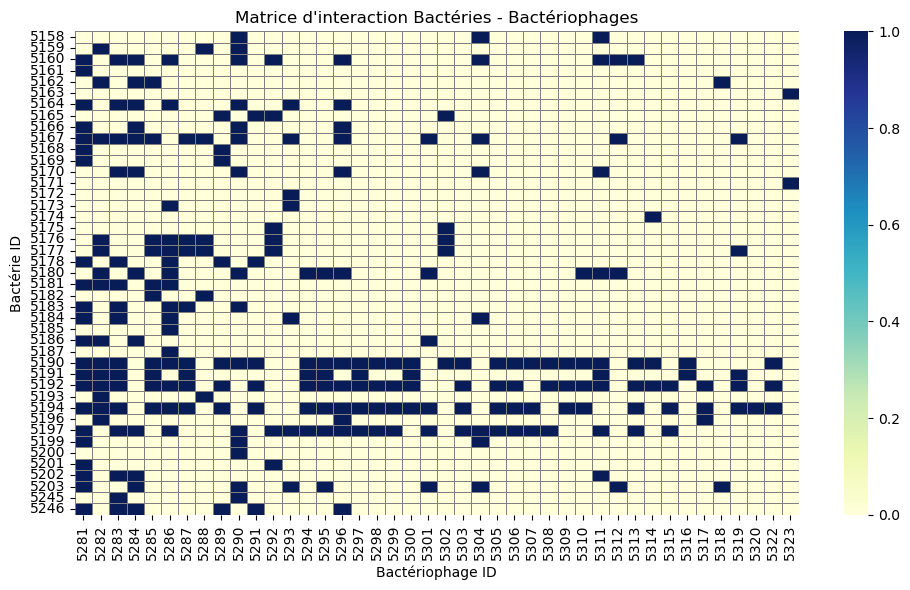

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

interaction_matrix = pd.crosstab(df['bacterium_id'], df['bacteriophage_id'])

plt.figure(figsize=(10, 6))
ax = sns.heatmap(interaction_matrix, cmap="YlGnBu", cbar=True, linewidths=0.5, linecolor='gray')

# Forcer l'affichage de tous les ticks sur Y
ax.set_yticks([i + 0.5 for i in range(len(interaction_matrix.index))])
ax.set_yticklabels(interaction_matrix.index, rotation=0)

# Forcer tous les ticks sur X aussi (optionnel)
ax.set_xticks([i + 0.5 for i in range(len(interaction_matrix.columns))])
ax.set_xticklabels(interaction_matrix.columns, rotation=90)

# Titres et labels
plt.title("Matrice d'interaction Bactéries - Bactériophages")
plt.xlabel("Bactériophage ID")
plt.ylabel("Bactérie ID")
plt.tight_layout()
plt.show()  

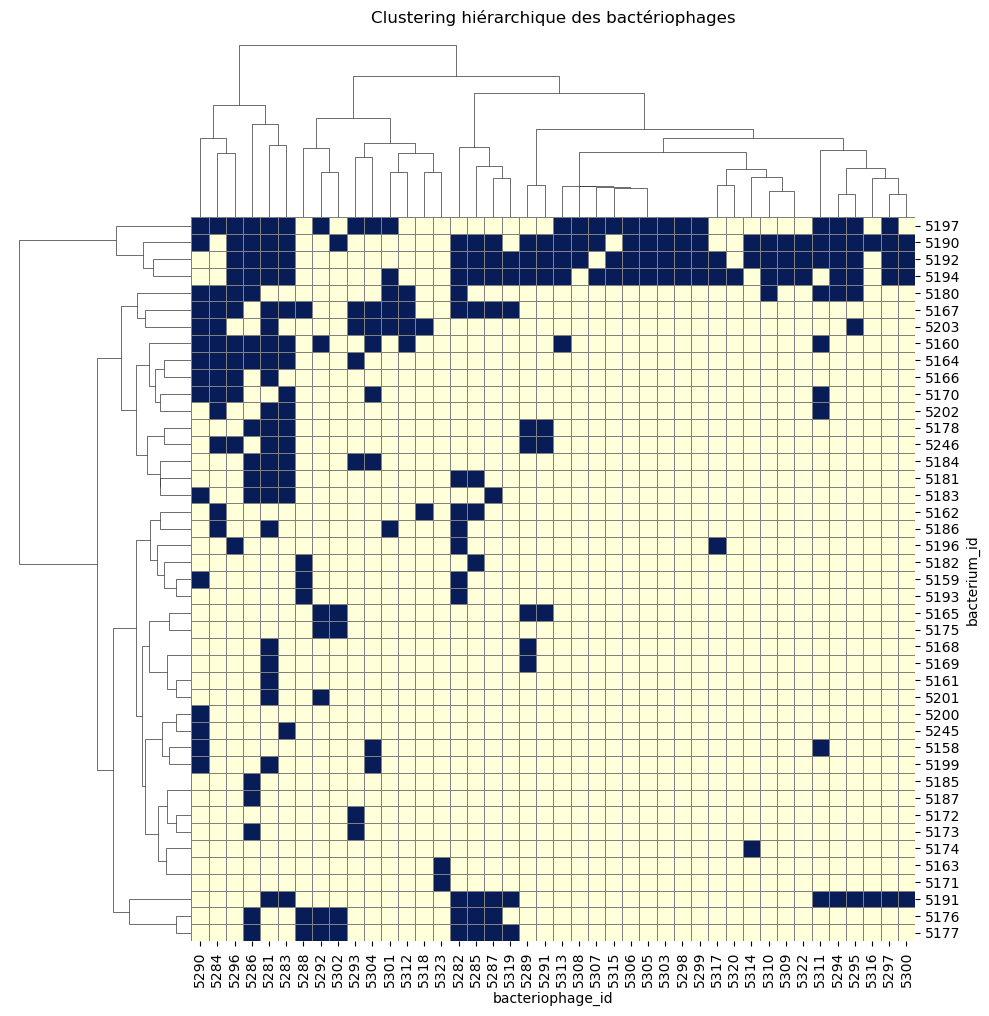

In [82]:
# Matrice d'interaction
interaction_matrix = pd.crosstab(df['bacterium_id'], df['bacteriophage_id'])

# Clustermap avec tri hiérarchique sur les colonnes (phages)
cluster = sns.clustermap(interaction_matrix, 
               cmap="YlGnBu",
               cbar_pos=None,
               linewidths=0.5, 
               linecolor='gray',
               col_cluster=True,    # tri hiérarchique sur les colonnes
               row_cluster=True,     # tri hiérarchique sur les lignes)
               method='ward',  # méthode de clustering
)

# Récupérer les bons ordres d’étiquettes après clustering
row_order = cluster.dendrogram_row.reordered_ind
col_order = cluster.dendrogram_col.reordered_ind

# Appliquer les étiquettes dans le bon ordre
ax = cluster.ax_heatmap
ax.set_yticks([i + 0.5 for i in range(len(row_order))])
ax.set_yticklabels(interaction_matrix.index[row_order], rotation=0)

ax.set_xticks([i + 0.5 for i in range(len(col_order))])
ax.set_xticklabels(interaction_matrix.columns[col_order], rotation=90)

plt.title("Clustering hiérarchique des bactériophages", pad=140)
plt.show()

### Clustering hierarchique et dendrogramme

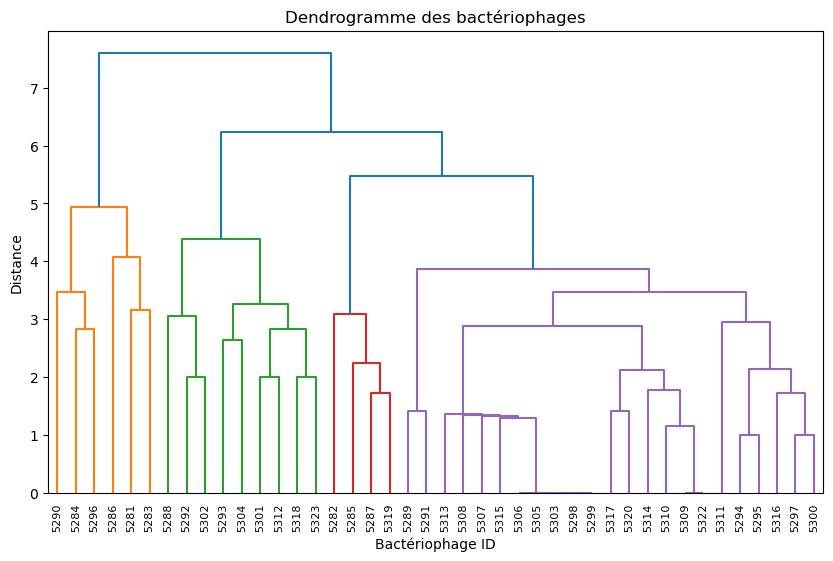

In [83]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import seaborn as sns

# Transposer pour grouper les colonnes (phages)
phage_matrix = interaction_matrix.T

# Étape 1: Calcul de la distance entre phages
dist_phages = pdist(phage_matrix.values, metric='euclidean')

# Étape 2: Clustering hiérarchique (Ward)
linkage_phages = linkage(dist_phages, method='ward')


plt.figure(figsize=(10, 6))
dendrogram(
    linkage_phages,
    labels=phage_matrix.index,
    leaf_rotation=90,
)
plt.title("Dendrogramme des bactériophages")
plt.xlabel("Bactériophage ID")
plt.ylabel("Distance")
plt.show()

cluster
2    36
1     6
Name: count, dtype: int64


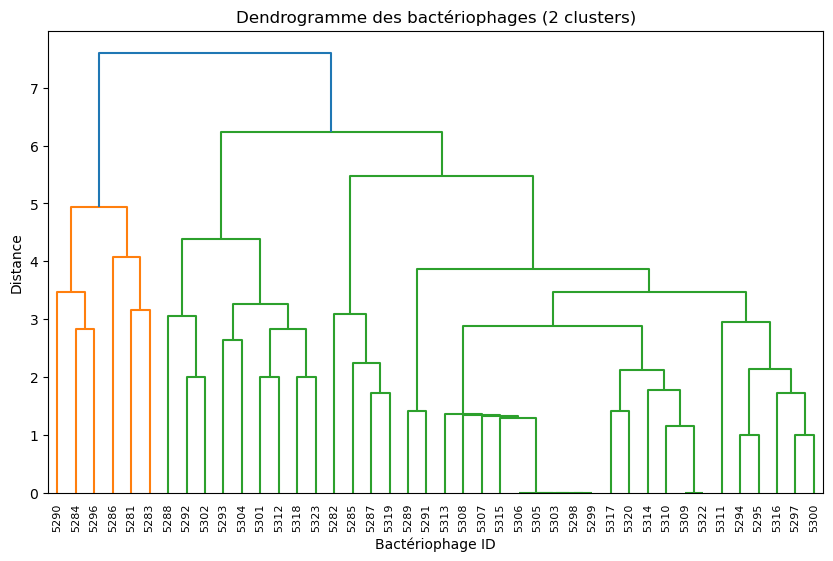

In [98]:
# Regrouper en clusters
from scipy.cluster.hierarchy import fcluster


n_clusters = 2  # Nombre de clusters souhaité
phage_clusters = fcluster(linkage_phages, t=n_clusters, criterion='maxclust')

# Créer un DataFrame pour associer les ID de phages à leurs groupes
phage_groups = pd.DataFrame({
    'phage_id': phage_matrix.index,
    'cluster': phage_clusters
})

# Affiche le nombre de phages par cluster
print(phage_groups['cluster'].value_counts())

# Afficher le dendrogramme
color_threshold = linkage_phages[-(n_clusters - 1), 2]  # seuil de distance
plt.figure(figsize=(10, 6))
dendrogram(
    linkage_phages,
    labels=phage_matrix.index,
    leaf_rotation=90,
    color_threshold=color_threshold
)

plt.title(f"Dendrogramme des bactériophages ({n_clusters} clusters)")
plt.xlabel("Bactériophage ID")
plt.ylabel("Distance")
plt.show()

## Séquences au format FASTA

In [85]:
phages_seqList = []

with open("data/assemblies.fasta", "r") as fasta_file:
    for line in fasta_file:
        if line.startswith(">"):
            # Si c'est une ligne d'en-tête, on ajoute l'ID de la protéine
            phage_id = line.strip().split()[0][1:]
            phages_seqList.append({"id": phage_id, "sequence": ""})
        else:
            # Si c'est une ligne de séquence, on ajoute la séquence
            phages_seqList[-1]["sequence"] += line.strip()

print("Nombre de séquences de bactériophages : ", len(phages_seqList))

Nombre de séquences de bactériophages :  42


In [86]:
phages_seqList[0:3] # Exemples

[{'id': '5281_Phage',
  'sequence': 'agcgacagcttacatccgctctcattttgcaatgagaattgcgtacagttcatcatgcgcctcagaagtgacttcactttgcatgcggatgcatgctatagtataccctgtgatagctccgctatcccgttttgcatggcacacgaattgcataagcatgacaagggtaaccctcgaaagcggagctttcaaagtgtaggctgagtgtgggctctaccctttagtatattgcgaccggaagtagtgacactgaaaaccttgactctagcccagtaaatacgttaaactaaaaggttgatagctgccgctatcgagtagcgaacattcacacaaggaggcacaatgacaagcaacaatcatgccaagattcacatccattacgctaagcaaatctactacgccatgcgtaaacgtgccatcgcaagcgatgagatatgcaaggaatgggccaagcccaagacgggctttgaagcgttctatgattgggtggtgaatgtgtcagggtacgccgtaggctaccgcctagacaggaatattctcttcccgggaaacaagctctatgctccgcatacatgcgagttctcgcctacatacattcataccctcttcaccaactgcgacaagacaagcaataaccgtgccaacaatgatctacctctaggcgtccgcctagcaaggtttgaccgatggagactgcctgtatacgtctcacagtgtagaacgctagggaagcaaaccacactaggatcgttcgacgatccaatggcagcgcatgtggcatggcaacatgccaagatggaatccatcctcgaatgtatcgatctctatcagatggaagacgttcacagtgtagacgttgttcaagctctgcttgatagagtggacaaacttgacaaggatattgcacaaggtagggaaaccattttgttgcagtagtctcccatggcccaacggctacccgtc

### Tailles des génomes

Text(0, 0.5, 'Longueur de la séquence (nucleotides)')

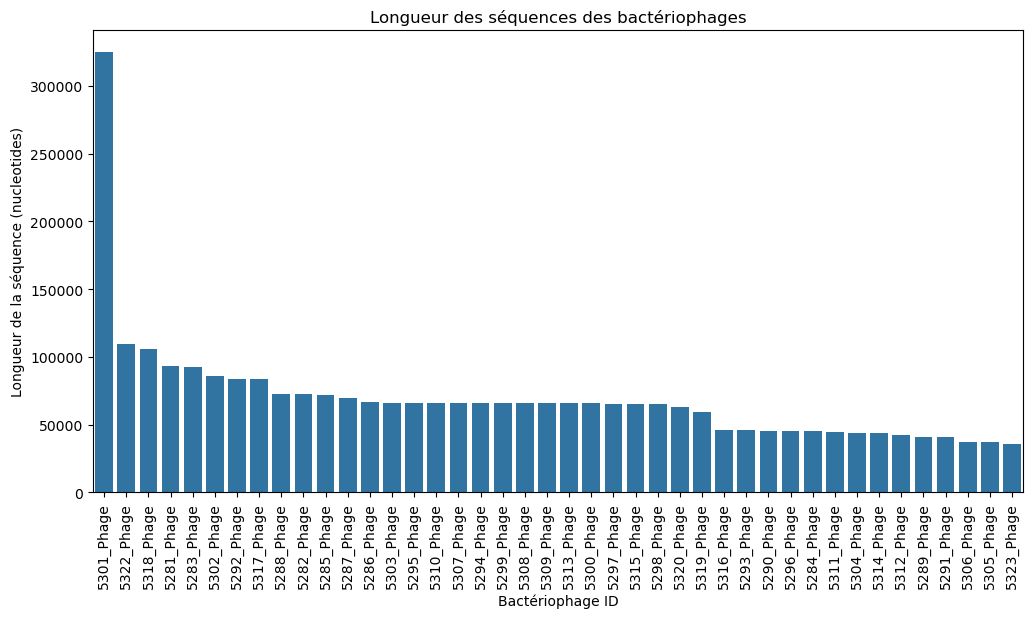

In [87]:
#Graphique de la longueur des séquences

phages_df = pd.DataFrame(phages_seqList)
phages_df['length'] = phages_df['sequence'].apply(len)

plt.figure(figsize=(12, 6))
sns.barplot(x='id', y='length', data=phages_df.sort_values('length', ascending=False))
plt.xticks(rotation=90)
plt.title("Longueur des séquences des bactériophages")
plt.xlabel("Bactériophage ID")
plt.ylabel("Longueur de la séquence (nucleotides)")

### Ratio GC

GC (%)
Min :  39.13
Max :  64.32
Moyenne :  55.21


Text(0, 0.5, 'GC (%)')

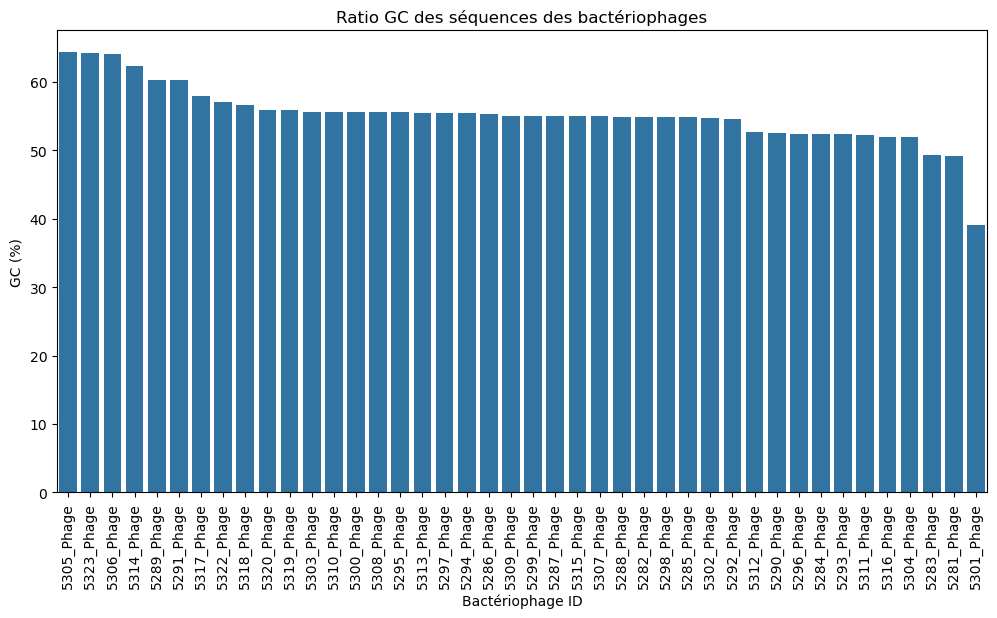

In [88]:
phages_df['gc_content'] = phages_df['sequence'].apply(lambda seq: (seq.count('g') + seq.count('c')) / len(seq) * 100)

print("GC (%)")
print("Min : ", phages_df['gc_content'].min().round(2))
print("Max : ", phages_df['gc_content'].max().round(2))
print("Moyenne : ", phages_df['gc_content'].mean().round(2))

plt.figure(figsize=(12, 6))
sns.barplot(x='id', y='gc_content', data=phages_df.sort_values('gc_content', ascending=False))
plt.xticks(rotation=90)
plt.title("Ratio GC des séquences des bactériophages")
plt.xlabel("Bactériophage ID")
plt.ylabel("GC (%)")


### Allignement de séquences

In [89]:
# from Bio import SeqIO
# from Bio.Align.Applications import MuscleCommandline
# from Bio import AlignIO
# import os

# # Chemins
# input_fasta = os.path.join(os.getcwd(), r"data/assemblies_without5301.fasta")
# aligned_fasta = os.path.join(os.getcwd(), r"data/aligned_sequences.fasta")

# # Muscle binaire : soit dans le PATH, soit chemin complet
# muscle_exe = r"C:\Users\remia\OneDrive\Documents\COURS\S6\BBC\Labos\Labo4\muscle3.8.31_i86win32.exe"

In [90]:
# Lancer Muscle
# muscle_cline = MuscleCommandline(muscle_exe, input=input_fasta, out=aligned_fasta)
# stdout, stderr = muscle_cline()

In [91]:
# alignment = AlignIO.read(aligned_fasta, "fasta")
# print(f"Alignement de {len(alignment)} séquences, longueur : {alignment.get_alignment_length()}")